In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import matplotlib.pyplot as plt
#%matplotlib plt.rcParams['figure.figsize'] = (12.0, 6.0)
%matplotlib plt.rc('figure', figsize=(20.0, 10.0))

UsageError: unrecognized arguments: = (12.0, 6.0)


In [18]:
import os, sys

DATAPATH = '/content/drive/My Drive/Coursera/EDHEC/investment-portfolio/data'
print(f"DATAPATH:{DATAPATH} contents:{os.listdir(DATAPATH)}")

MODULEPATH = '/content/drive/My Drive/Coursera/EDHEC/investment-portfolio/nb'
print(f"MODULEPATH:{MODULEPATH} contents:{os.listdir(MODULEPATH)}")

sys.path.append(MODULEPATH)
print(f"sys.path:{sys.path}")

import numpy as np
import pandas as pd

import edhec_risk_kit_109_BBI as erk

DATAPATH:/content/drive/My Drive/Coursera/EDHEC/investment-portfolio/data contents:['sample_prices.csv', 'edhec-hedgefundindices.csv', 'ind30_m_vw_rets.csv', 'Portfolios_Formed_on_ME_monthly_EW.csv', 'ind30_m_ew_rets.csv']
MODULEPATH:/content/drive/My Drive/Coursera/EDHEC/investment-portfolio/nb contents:['lab_101.ipynb', 'lab_102.ipynb', 'lab_103.ipynb', 'hello.py', '__pycache__', 'edhec_risk_kit_104_BBI.py', 'lab_104.ipynb', 'edhec_risk_kit_105_BBI.py', 'lab_105.ipynb', 'edhec_risk_kit_106_BBI.py', 'lab_106.ipynb', 'module_1_quiz.ipynb', 'edhec_risk_kit_107_BBI.py', 'lab_107.ipynb', 'edhec_risk_kit_108_BBI.py', 'lab_108.ipynb', 'edhec_risk_kit_109_BBI.py', 'lab_109.ipynb']
sys.path:['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Coursera/EDHEC/investment-

# Efficient Frontier - Part III - Running the Optimizer

In order to plot the frontier for portfolios with more than 2 assets, we need to find the weights of the portfolio on the efficient frontier.

We start by creating the same sort of function that we already created for the 2 asset case:

```python

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = ???? # we need to implement: optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```

But let's start by loading up the data as usual:


In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit_109_BBI as erk

ind = erk.get_ind_returns(DATAPATH)
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In order to find the optimal weights, we need a function that will minimize the volatility for a given level of return.


```python
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - erk.portfolio_return(weights,er)
    }
    weights = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x
```

Let's use this to recreate the result we got from frontier for the 2-Asset optimization between "Games" and "Fin". Let's plot that efficient frontier as we did last time:

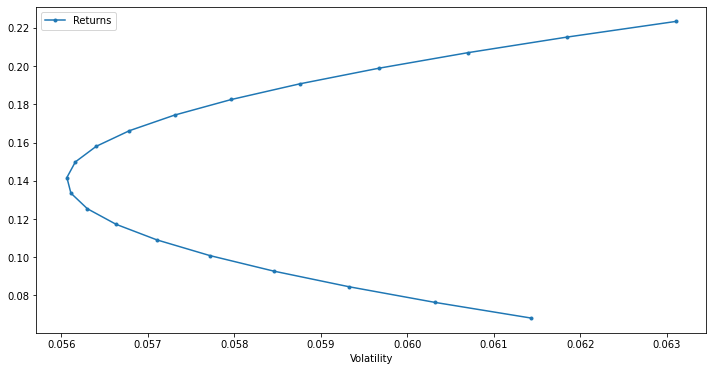

In [13]:
l = ["Games", "Fin"]
erk.plot_ef2(20, er[l], cov.loc[l,l])

The Efficient Frontier for the protfolio that has a target return of 0.15 is approx 0.056, so let's see if our optimizer is able to locate it.

In [14]:
weights_15 = erk.minimize_vol(0.15, er[l], cov.loc[l,l])
vol_15 = erk.portfolio_vol(weights_15, cov.loc[l,l])
vol_15

0.056163669406706564

Perfect!

Now that we can find the weights to minimize the vol given a target return, we can plot the efficient frontier by dividing up the range from the highest to the lowest possible return into a grid, and finding the portfolio that targets the minimum volatility given a particular targeted rate of return.

Add these:

```python
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```


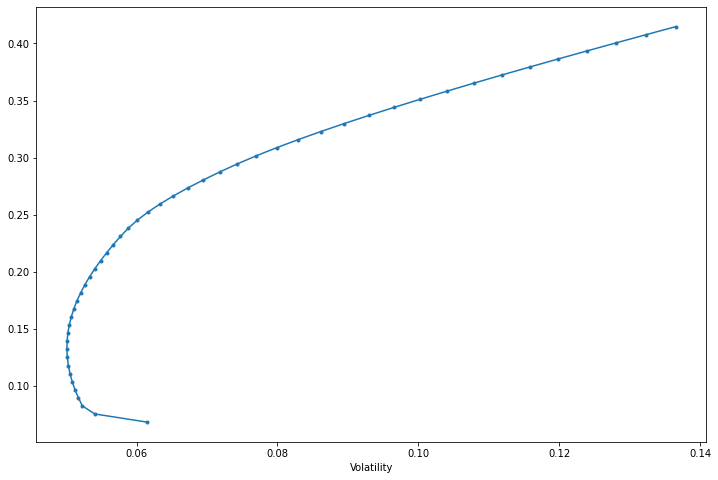

In [19]:
l = ["Smoke", "Fin", "Games", "Coal"]
erk.plot_ef(50, er[l], cov.loc[l,l])